In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.9 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,SimpleRNN
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model, set_random_seed
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [5]:
set_random_seed(66)

In [6]:
def fetch_and_clean_stock_data(ticker, start_date, end_date, file_name='stock_data.csv'):
    """
    Fetch stock data for the given ticker from Yahoo Finance, using the provided start date
    and the current date as the end date.
    Saves the data to a CSV file and downloads it.

    Args:
    - ticker (str): Stock ticker symbol (e.g., 'TSLA').
    - start_date (str): Start date for fetching data in 'YYYY-MM-DD' format.
    - end_date (str): End date for fetching data in 'YYYY-MM-DD' format.
    - file_name (str): Name of the CSV file to save the data. Default is 'stock_data.csv'.

    Returns:
    - data (DataFrame): The stock data fetched from Yahoo Finance.
    """
    # Fetch data from Yahoo Finance
    data = yf.download(ticker, start=start_date, end=end_date)

    # If the data has a multi-level column index, drop the second level
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)

    # Rename the columns for better readability
    data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

    # Drop NaN rows
    data = data.dropna()

    # Save the data to a CSV file
    data.to_csv(file_name)

    # Download the CSV file (for Google Colab compatibility)
    try:
        from google.colab import files
        files.download(file_name)
        print(f"Data for {ticker} saved to {file_name} and downloaded.")
    except ImportError:
        print(f"Data for {ticker} saved to {file_name}. No download as this isn't Google Colab.")

    # Return the DataFrame
    return data
# Fetch data for Tesla and JPMorgan
data_tesla = fetch_and_clean_stock_data(
    ticker='TSLA',
    start_date="2014-09-19",
    end_date="2024-09-19",
    file_name='tesla_stock_data_with_returns.csv'
)

data = fetch_and_clean_stock_data(
    ticker='JPM',
    start_date="2014-09-19",
    end_date="2024-09-19",
    file_name='jpm_stock_data_with_returns.csv'
)
data_greegs = fetch_and_clean_stock_data(
    ticker='GRG.L',
    start_date="2014-09-19",
    end_date="2024-09-19",
    file_name='greeegs_stock_data_with_returns.csv'
)

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data for TSLA saved to tesla_stock_data_with_returns.csv and downloaded.


[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data for JPM saved to jpm_stock_data_with_returns.csv and downloaded.


[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data for GRG.L saved to greeegs_stock_data_with_returns.csv and downloaded.


# **DATA** **PREPROCESSING**

In [7]:
def explore_dataset(data, dataset_name):
    """
    Function to explore a dataset by showing head, tail, info, columns,
    descriptive statistics, and missing value checks.

    Parameters:
    - data: DataFrame to be explored.
    - dataset_name: String representing the name of the dataset.
    """
    print(f"\n--- {dataset_name.upper()} ---")

    # Quick look at the dataset
    print("\nHead of the dataset:")
    print(data.head())

    print("\nTail of the dataset:")
    print(data.tail())

    # Data types and non-null values
    print("\nDataset Info:")
    data.info()

    print("\nColumns in the dataset:")
    print(data.columns)

    # Descriptive statistics
    print(f"\n{dataset_name} Statistical Value:")
    print(data.describe())

    # Check for missing values
    print("\nMissing values:")
    print(data.isnull().sum())

In [8]:
# Explore  function call JP Morgan    dataset
explore_dataset(data, "JP Morgan")


--- JP MORGAN ---

Head of the dataset:
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-09-19  46.047894  61.110001  61.849998  60.980000  61.740002  18739300
2014-09-22  45.897190  60.910000  61.450001  60.799999  60.939999  13225200
2014-09-23  45.919792  60.939999  61.400002  60.770000  60.820000  14328800
2014-09-24  46.439724  61.630001  61.639999  61.020000  61.180000  13728200
2014-09-25  45.324516  60.150002  61.500000  60.150002  61.490002  16340100

Tail of the dataset:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-12  205.341675  206.600006  208.779999  204.889999  207.649994   
2024-09-13  203.075562  204.320007  207.850006  203.020004  206.860001   
2024-09-16  206.593994  207.860001  208.210007  205.589996  205.830002   
2024-09-17  207.975525  209.250000 

In [9]:
# Explore function call Tesla stock
explore_dataset(data_tesla, "Tesla")


--- TESLA ---

Head of the dataset:
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2014-09-19  17.288000  17.288000  17.428667  17.018000  17.199333  102163500
2014-09-22  16.668667  16.668667  17.068001  16.313999  17.000000  123211500
2014-09-23  16.694000  16.694000  16.920000  16.333332  16.348000   84880500
2014-09-24  16.809334  16.809334  16.856001  16.469334  16.741333   56242500
2014-09-25  16.463333  16.463333  16.997334  16.406668  16.834667   72513000

Tail of the dataset:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-12  229.809998  229.809998  231.449997  223.830002  224.660004   
2024-09-13  230.289993  230.289993  232.669998  226.320007  228.000000   
2024-09-16  226.779999  226.779999  229.960007  223.529999  229.300003   
2024-09-17  227.869995  227.8699

In [10]:
# Explore function call greggs stock
explore_dataset(data_greegs, "Greegs")


--- GREEGS ---

Head of the dataset:
                  Open   High      Low  Close  Adj Close  Volume
Date                                                            
2014-09-19  456.822205  595.5  600.000  590.0      598.0  124776
2014-09-22  452.603241  590.0  598.375  590.0      595.0  107552
2014-09-23  463.342804  604.0  649.000  590.5      592.0  799872
2014-09-24  458.740112  598.0  611.500  597.0      611.5  121057
2014-09-25  454.520935  592.5  605.750  590.0      605.0   98821

Tail of the dataset:
              Open    High     Low   Close  Adj Close  Volume
Date                                                         
2024-09-12  3152.0  3152.0  3200.0  3150.0     3200.0   80998
2024-09-13  3172.0  3172.0  3186.0  3130.0     3130.0  116436
2024-09-16  3176.0  3176.0  3200.0  3154.0     3200.0  140733
2024-09-17  3182.0  3182.0  3202.0  3170.0     3180.0  130637
2024-09-18  3166.0  3166.0  3190.0  3152.0     3186.0  128722

Dataset Info:
<class 'pandas.core.frame.DataFrame'

In [11]:
def check_data_quality(data):
    """
    Checks the DataFrame for duplicate and missing values.

    Parameters:
    - data (pandas.DataFrame): The dataset to check.

    Returns:
    - None: Prints the results of the checks.
    """
    # Check for duplicates
    duplicates = data.duplicated()
    if duplicates.any():
        print("The DataFrame has duplicates.")
        print(f"Number of duplicate rows: {duplicates.sum()}")
    else:
        print("The DataFrame does not have duplicates.")
    print("\n" + "="*50 + "\n")

    # Check for missing values
    missing_values = data.isnull().sum()
    print("Missing Values:")
    print(missing_values)
    print("\n" + "="*50 + "\n")


In [12]:
# function call duplicate value or not jp morgan stock
check_data_quality(data)


The DataFrame does not have duplicates.


Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64




In [13]:
# function call duplicate value or not tesla stock
check_data_quality(data_tesla)

The DataFrame does not have duplicates.


Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64




In [14]:
# function call duplicate valur or not greegs stock
check_data_quality(data_greegs)

The DataFrame does not have duplicates.


Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64




In [15]:
# Outlier detection
close_prices = data['Close']
# Calculate daily returns
daily_returns = close_prices.pct_change()
# Calculating z-scores for each data point
z_scores = (daily_returns - daily_returns.mean()) / daily_returns.std()
# Set a threshold for identifying outliers
threshold = 3
# Identify outliers
outliers = z_scores[abs(z_scores) > threshold]
"""# Remove outliers from the 'data' DataFrame
data = data[data.index.isin(outliers.index) == False]"""
print(data)




                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-19   46.047894   61.110001   61.849998   60.980000   61.740002   
2014-09-22   45.897190   60.910000   61.450001   60.799999   60.939999   
2014-09-23   45.919792   60.939999   61.400002   60.770000   60.820000   
2014-09-24   46.439724   61.630001   61.639999   61.020000   61.180000   
2014-09-25   45.324516   60.150002   61.500000   60.150002   61.490002   
...                ...         ...         ...         ...         ...   
2024-09-12  205.341675  206.600006  208.779999  204.889999  207.649994   
2024-09-13  203.075562  204.320007  207.850006  203.020004  206.860001   
2024-09-16  206.593994  207.860001  208.210007  205.589996  205.830002   
2024-09-17  207.975525  209.250000  209.929993  207.660004  207.729996   
2024-09-18  206.265991  207.529999  211.339996  206.699997  209.009995   

              Volume  
Date          

# **EXPLORATORY** **DATA** **ANALYSIS**

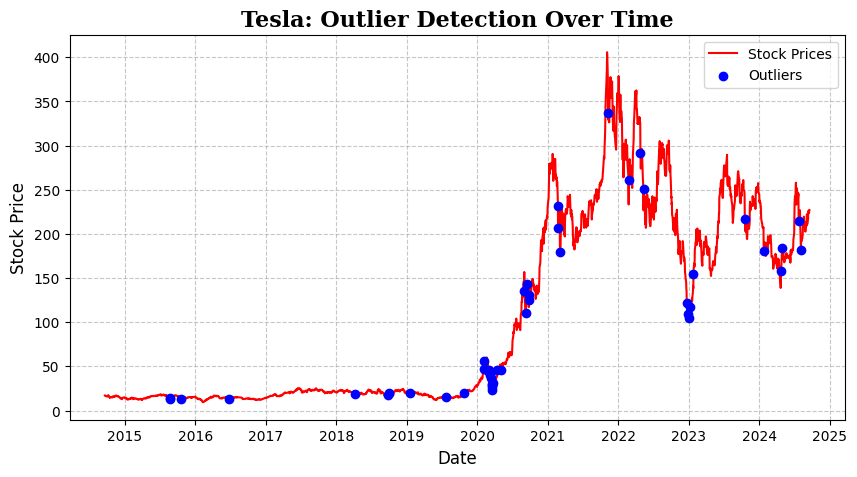

Number of outliers: 46
Outliers: Date
2015-08-24   -4.602337
2015-08-25    3.610001
2015-10-20   -3.062809
2016-06-22   -3.163502
2018-04-05    4.200139
2018-09-28   -4.512798
2018-10-01    4.547425
2019-01-18   -3.863778
2019-07-25   -3.782330
2019-10-24    4.405227
2020-02-04    6.992609
2020-02-05   -4.648824
2020-02-27   -4.128036
2020-03-02    3.586292
2020-03-09   -3.472725
2020-03-12   -3.267066
2020-03-16   -3.571398
2020-03-17   -3.134783
2020-03-18   -3.443974
2020-03-20    5.506477
2020-03-24    4.526531
2020-04-14    5.652059
2020-05-01   -3.163353
2020-09-02   -4.156661
2020-09-08   -3.396657
2020-09-15    4.499159
2020-09-23   -3.001350
2020-09-25    3.319361
2021-02-23   -3.844352
2021-02-24    3.543340
2021-03-05   -3.029316
2021-11-09   -3.217658
2022-02-25    3.433241
2022-04-26   -3.088163
2022-05-13    3.064694
2022-12-22   -3.013104
2022-12-27   -3.042785
2023-01-03   -3.778266
2023-01-09    4.396151
2023-01-26    3.526864
2023-10-19   -3.137563
2024-01-25   -3.866

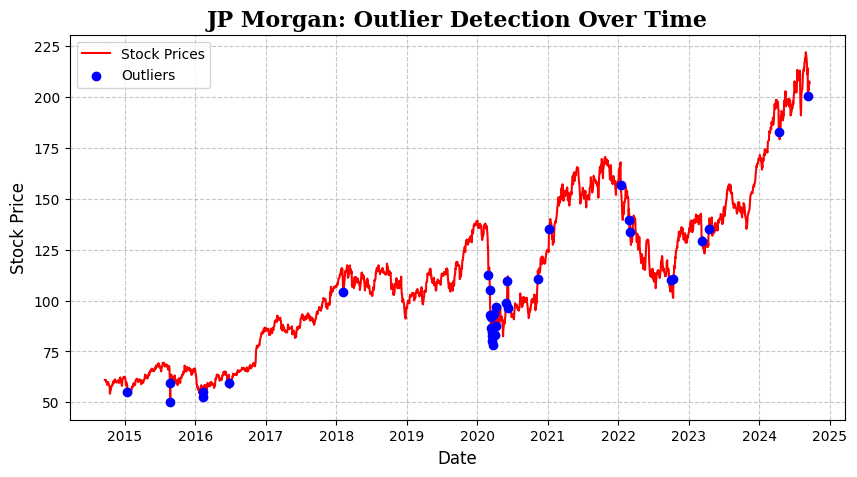

Number of outliers: 35
Outliers: Date
2015-01-14    -3.242527
2015-08-24   -12.852720
2015-08-25    11.604651
2016-02-11    -3.268658
2016-02-12     3.031307
2016-06-24    -4.017572
2018-02-05    -5.385051
2020-02-28    -4.335907
2020-03-06    -4.089939
2020-03-09    -6.944369
2020-03-12    -5.290294
2020-03-13     3.933133
2020-03-16    -4.924261
2020-03-18    -4.961781
2020-03-20     4.332653
2020-03-23    -3.249506
2020-03-24     3.679322
2020-03-26     6.386557
2020-04-01    -4.151142
2020-04-06     3.556641
2020-04-09     4.187477
2020-05-27     3.995758
2020-06-05     3.919186
2020-06-11    -5.345250
2020-11-09     4.653666
2021-01-07     3.284424
2022-01-14    -3.987791
2022-02-24    -3.377677
2022-03-01    -3.164545
2022-10-04     3.081836
2022-10-14     5.275720
2023-03-09    -3.418790
2023-04-14     3.801988
2024-04-12    -3.379037
2024-09-10    -3.860966
Name: Close, dtype: float64


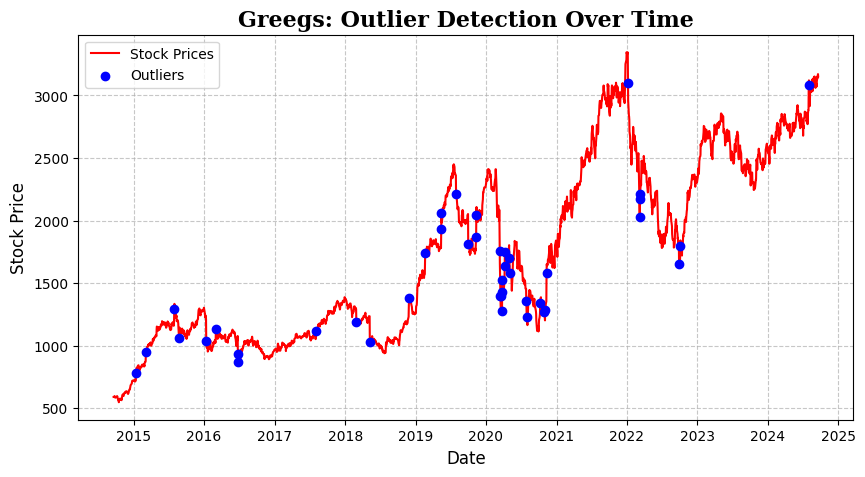

Number of outliers: 42
Outliers: Date
2015-01-13    3.721058
2015-03-05    4.349874
2015-07-30    4.226451
2015-08-24   -3.606076
2016-01-12   -7.424274
2016-03-02    4.033089
2016-06-24   -7.168087
2016-06-27   -3.429889
2017-08-02    3.219180
2018-02-28   -3.998906
2018-05-09   -8.804864
2018-11-28    3.463877
2019-02-20    3.153394
2019-05-14    4.458619
2019-05-15    3.427142
2019-07-30   -3.391579
2019-10-01   -6.102647
2019-11-11    3.297382
2019-11-12    4.679506
2020-03-12   -5.841374
2020-03-16   -8.224619
2020-03-20    4.412028
2020-03-23   -4.298059
2020-03-25    6.251552
2020-03-26    3.481714
2020-04-07    3.790972
2020-04-08    3.369410
2020-05-01   -3.073448
2020-05-04   -3.643296
2020-07-28   -3.657450
2020-07-30   -3.482981
2020-10-08    3.340988
2020-10-28   -3.194387
2020-11-03    3.464617
2020-11-10    8.638000
2022-01-06   -3.809677
2022-03-07   -3.485154
2022-03-08   -3.598742
2022-03-09    4.794970
2022-09-28   -3.951268
2022-10-04    3.913903
2024-07-31    3.565

In [16]:
def plot_outliers(data, company_name, column='Close', threshold=3):
    """
    Plots stock prices with identified outliers and displays the number of outliers.

    Parameters:
    - data (pandas.DataFrame): The dataset containing the column.
    - company_name (str): The name of the company for the plot title.
    - column (str): The column name to analyze (default is 'Close').
    - threshold (float): The z-score threshold to identify outliers (default is 3).

    Returns:
    - None
    """
    # Calculate daily returns
    close_prices = data[column]
    daily_returns = close_prices.pct_change()

    # Calculate z-scores for daily returns
    z_scores = (daily_returns - daily_returns.mean()) / daily_returns.std()

    # Identify outliers based on the threshold
    outliers = z_scores[abs(z_scores) > threshold]

    # Plot stock prices with outliers
    plt.figure(figsize=(10, 5))
    plt.plot(close_prices.index, close_prices.values, label='Stock Prices', color='red')
    plt.scatter(outliers.index, close_prices[outliers.index], color='blue', label='Outliers', zorder=5)
    plt.title(
        f"{company_name}: Outlier Detection Over Time",
        fontsize=16, fontweight='bold', fontfamily='serif'
    )
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print(f"Number of outliers: {len(outliers)}")
    print(f"Outliers: {outliers}")
# function call jp morgan ,greegs,tesla stock with outliers
# function call outliers
plot_outliers(data_tesla,'Tesla', column='Close', threshold=3)
plot_outliers(data,'JP Morgan', column='Close', threshold=3)
plot_outliers(data_greegs,'Greegs', column='Close', threshold=3)


In [17]:
# Extract the 'open' prices from the DataFrame
df2 = data.reset_index()['Open']
df2

,Open
0,46.047894
1,45.897190
2,45.919792
3,46.439724
4,45.324516
...,...
2511,205.341675
2512,203.075562
2513,206.593994
2514,207.975525


**OPENING** **PRICE** **PLOT**

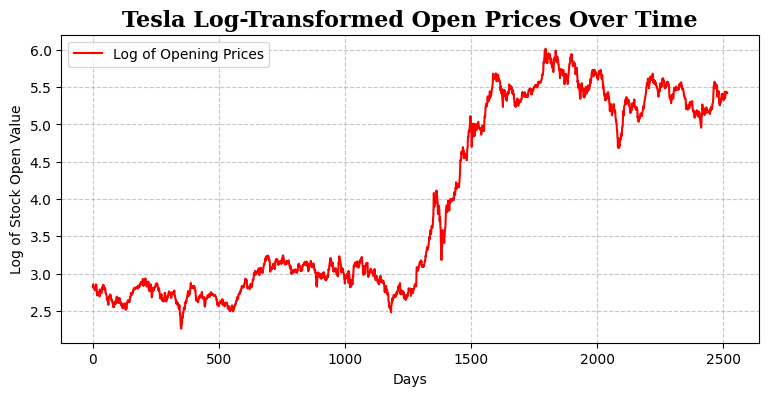

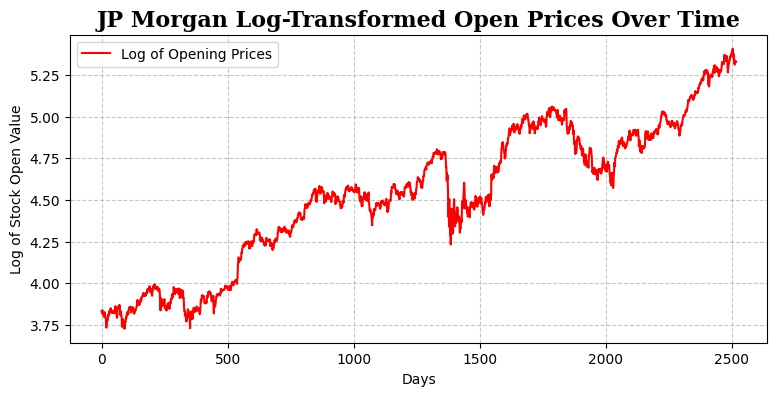

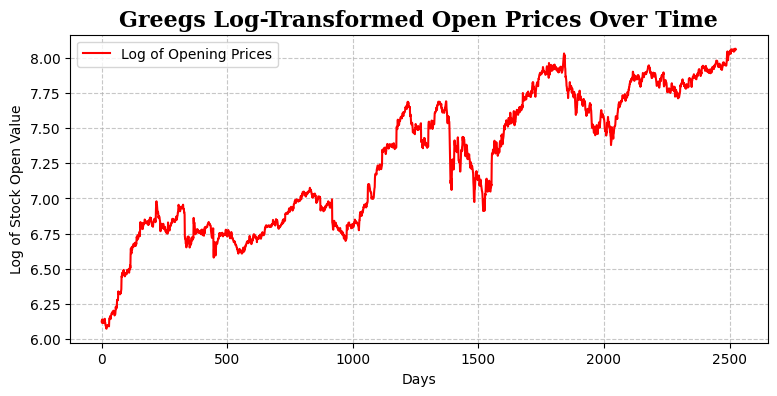

In [18]:
def plot_opening_prices(data, company_name):
    """
    Plots the logarithm of opening prices of a stock to inspect trends.

    Parameters:
    - data (Pandas Series): Contains the opening prices of the stock.
    - company_name (str): The name of the company for labeling the plot.

    Returns:
    - None
    """
    # Apply logarithm to the opening prices
    log_data = np.log(data)

    plt.figure(figsize=(9, 4))  # Set the figure size
    plt.plot(log_data, color='r', label='Log of Opening Prices')  # Plot log-transformed data
    plt.xlabel('Days')  # X-axis label
    plt.ylabel('Log of Stock Open Value')  # Y-axis label with log context
    plt.title(
        f"{company_name} Log-Transformed Open Prices Over Time",
        fontsize=16, fontweight='bold', fontfamily='serif'
    )  # Title with formatting
    plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
    plt.legend(loc='upper left', fontsize=10)  # Add a legend in the upper-left corner
    plt.show()  # Display the plot
# function call
# Extract 'Open' prices for Tesla, JP Morgan,Tesco,Greegs from their respective DataFrames
tesla_open_prices = data_tesla.reset_index()['Open']
jpm_open_prices = data.reset_index()['Open']

greegs_open_prices = data_greegs.reset_index()['Open']
#  function calls
plot_opening_prices(tesla_open_prices, 'Tesla')
plot_opening_prices(jpm_open_prices, 'JP Morgan')

plot_opening_prices(greegs_open_prices, 'Greegs')

**CLOSING** **PRICE** **PLOT**

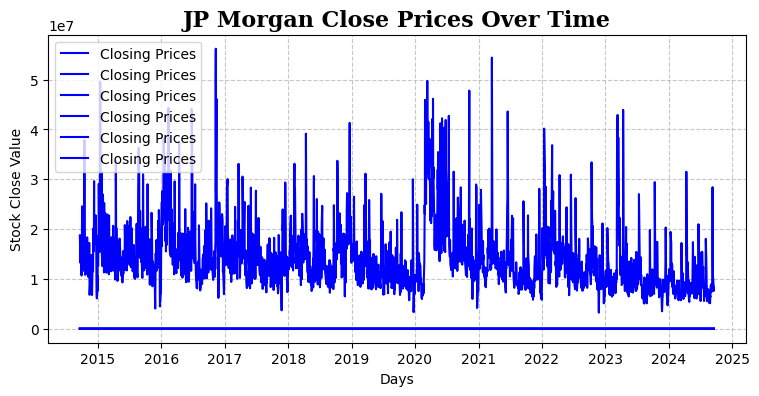

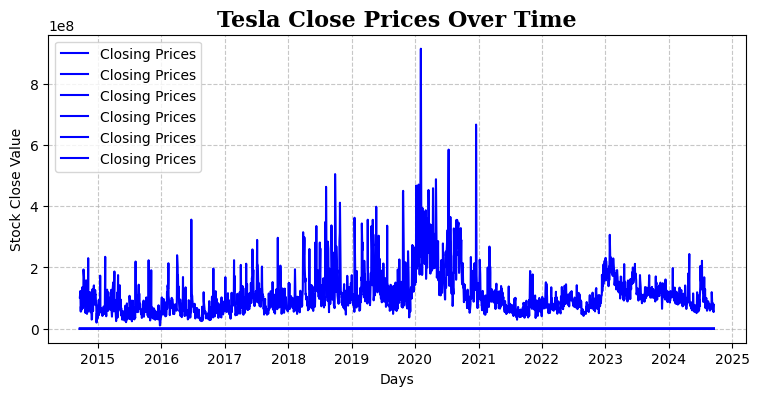

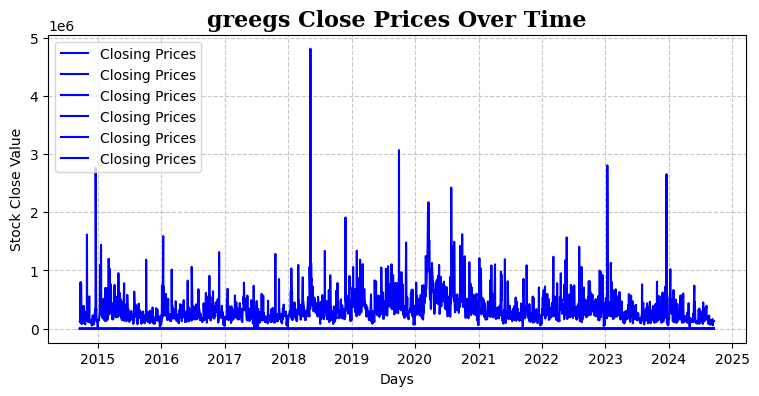

In [19]:
def plot_closing_prices(data, company_name):
    """
    Plots the closing prices of a stock to inspect trends.

    Parameters:
    - data: Pandas Series containing closing prices.
    - company_name: String representing the company name for plot labeling.

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    plt.plot(data, color='b', label='Closing Prices')
    plt.xlabel('Days')
    plt.ylabel('Stock Close Value')
    plt.title(f"{company_name} Close Prices Over Time", fontsize=16, fontweight='bold', fontfamily='serif')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=10)
    plt.show()
# function call
plot_closing_prices(data,'JP Morgan')
plot_closing_prices(data_tesla,'Tesla')
plot_closing_prices(data_greegs,'greegs')

**VOLATILITY** **PLOT**

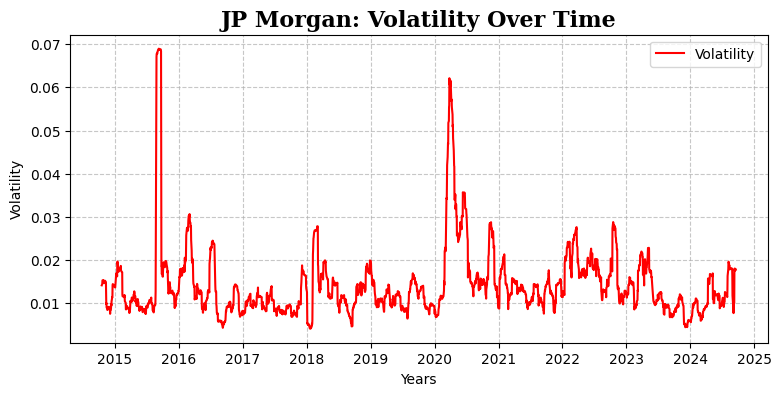

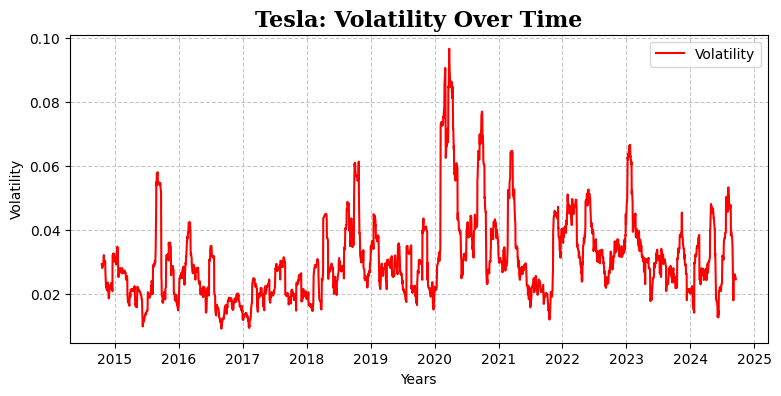

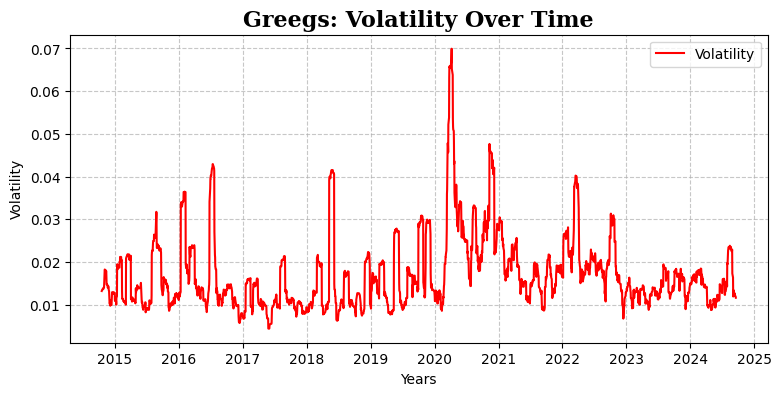

In [20]:
def plot_volatility(data, company_name, column='Close', window_size=20):
    """
    Plots the rolling volatility of stock prices over time.

    Parameters:
    - data (pandas.DataFrame): The dataset containing the column.
    - company_name (str): The name of the company for the plot title.
    - column (str): The column name to analyze (default is 'Close').
    - window_size (int): The rolling window size for calculating volatility (default is 20).

    Returns:
    - None
    """
    close_prices = data[column]
    # Calculate daily returns
    daily_returns = close_prices.pct_change()

    # Calculate rolling volatility
    volatility = daily_returns.rolling(window=window_size).std()

    # Plot volatility over time
    plt.figure(figsize=(9, 4))
    plt.plot(volatility.index, volatility.values, color='red', label='Volatility')
    plt.title(f'{company_name}: Volatility Over Time', fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Years')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
# function call
plot_volatility(data,'JP Morgan')
plot_volatility(data_tesla,'Tesla')
plot_volatility(data_greegs,'Greegs')

**STOCK** **PERFORMANCE** **AND** **VOLUME** **OVER** **TIME**

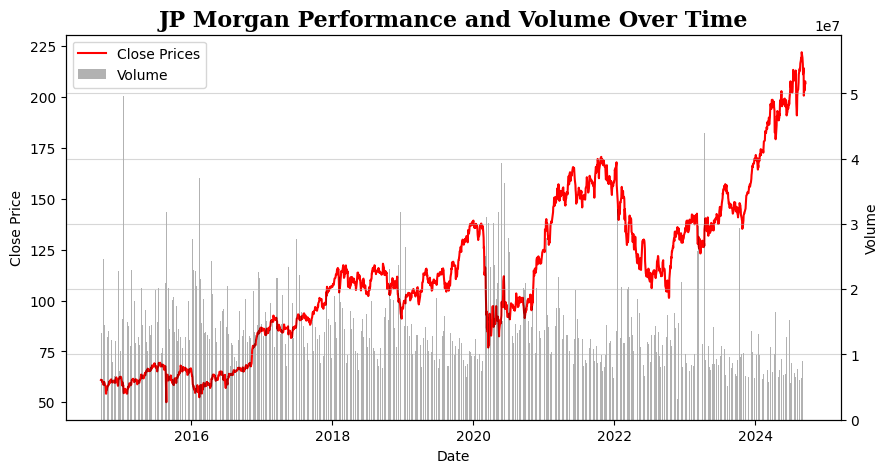

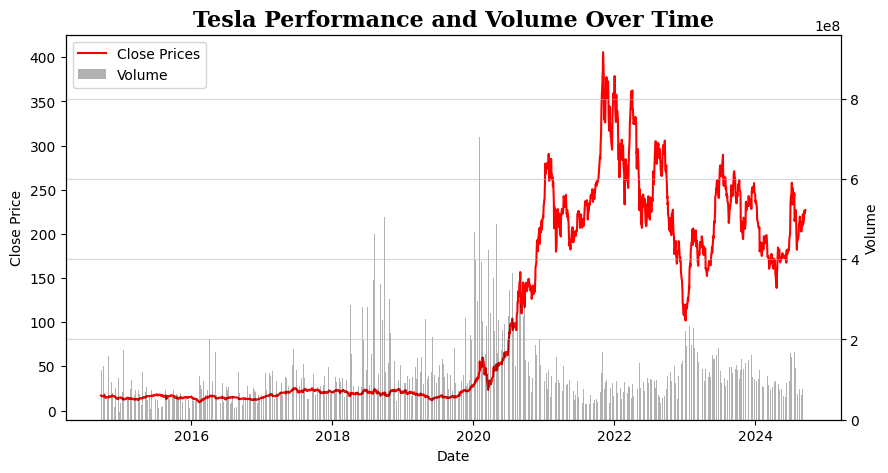

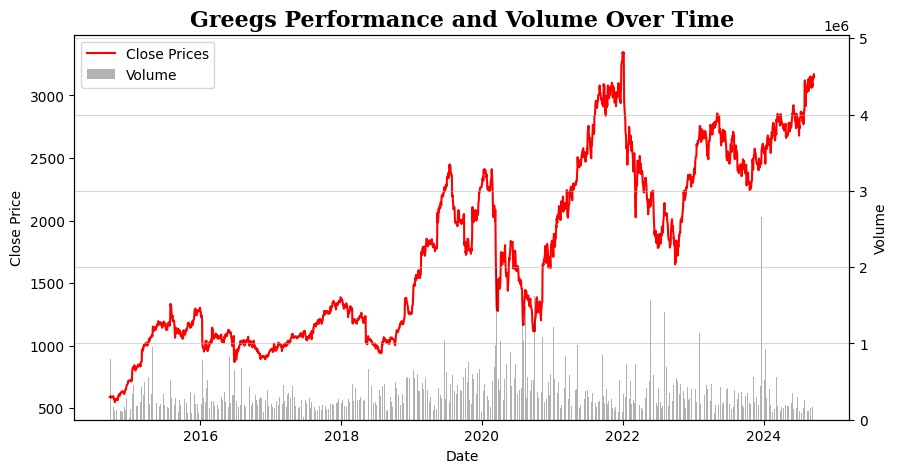

In [21]:
def plot_stock_volume(data, stock_name='Stock'):
    """
    Plots the stock performance and volume over time.

    Parameters:
    - data (pandas.DataFrame): The dataset containing 'Close' prices and 'Volume'.
    - stock_name (str): The name of the stock for labeling.

    Returns:
    - None
    """
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot 'Close' prices on the first y-axis
    ax1.plot(data.index, data['Close'], label='Close Prices', color='red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Create second y-axis for volume data
    ax2 = ax1.twinx()
    ax2.bar(data.index, data['Volume'], label='Volume', color='black', alpha=0.3)
    ax2.set_ylabel('Volume', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Title and legend
    plt.title(f'{stock_name} Performance and Volume Over Time', fontsize=16, fontweight='bold', fontfamily='serif')
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax1.legend(lines, labels, loc='upper left')
    plt.grid(alpha=0.5)
    plt.show()
# function call
plot_stock_volume(data,'JP Morgan')
plot_stock_volume(data_tesla,'Tesla')
plot_stock_volume(data_greegs,'Greegs')

**MIN** **MAX** **SCALING**

In [22]:
# Scale the data to a range between 0 and 1 as LSTMs are sensitive to scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

**TIME** **SERIES** **GENERATOR**

In [23]:
# Create the time series data structure
look_back = 50
train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)

**NUMPY** **ARRAY** **CREATION**

In [24]:
def create_dataset(dataset, time_step = 1):
  """
  Create sequences of 'time_step' consecutive values from the input time
  series 'dataset'.
  Parameters:
  - dataset (numpy.ndarray): Input time series data.
  - time_step (int): Number of consecutive time steps in each sequence.
  Returns:
  - numpy.ndarray, numpy.ndarray: Tuple containing dataX and dataY.
  """
  dataX,dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX),np.array(dataY)

**SPLITTING** **DATA**

In [25]:
# Call the function to split the data into input-output datasets
# with a time step of 50
time_step = 50
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [26]:
# Display the shapes of the training and testing datasets
print(X_train.shape)
print(X_test.shape)

(1961, 50)
(503, 50)


# **LONG** **SHORT**-**TERM** **MEMORY**(**LSTM**)

In [27]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Compile and fit LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_generator, epochs=50, batch_size=32,
               validation_data=(X_test, Y_test))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0079 - val_loss: 0.0379
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.1955e-04 - val_loss: 0.0012
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.0153e-04 - val_loss: 0.0034
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 9.3710e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.3375e-04 - val_loss: 0.0013
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7692e-04 - val_loss: 0.0082
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.8201e-04 - val_loss: 0.0019
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8566e-04 - val_loss: 4.7849e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 7.4141e-04 - val_loss: 0.0033
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━

In [29]:
# Build the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(128, return_sequences=True,
                        input_shape=(X_train.shape[1],1)))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(1))

In [30]:
# Compile and fit RNN model
rnn_model.compile(loss = 'mean_squared_error', optimizer='adam')
rnn_model.fit(train_generator, epochs=50, batch_size=32)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.3337
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0060
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0014
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.2859e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.4854e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 6.1988e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.2363e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.7541e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.9103e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0027
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.4177e-04
Epoch 13/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.4858e-04
Epoch 14/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.8430e-04
Epoch 15/50
99/99 ━━━━━━━━━━━━━━━━

In [31]:
from tensorflow.keras.layers import GRU, Dense
# Define the LSTM model
gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
gru_model.add(GRU(128, return_sequences=True))
gru_model.add(GRU(64))
gru_model.add(Dense(1))

In [ ]:
# Compile and fit LSTM model
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(train_generator, epochs=50, batch_size=32,
               validation_data=(X_test, Y_test))

Epoch 1/50


In [33]:
# Predicting on the dataset with our models
rnn_predictions = rnn_model.predict(test_generator)
lstm_predictions = lstm_model.predict(test_generator)
gru_predictions = gru_model.predict(test_generator)

# Inverting out models
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)
actual_prices = scaler.inverse_transform(test_data[look_back:])

504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [34]:
vals1 = Y_test.reshape(-1, 1)
actual_values = scaler.inverse_transform(vals1)

**MSE**,**MAE** **AND** **RMSE** **OF** **LSTM** **AND** **RNN** **MODELS**

In [35]:

def calculate_model_errors(actual_values, predictions):
    """
    Calculates MSE, MAE, and RMSE of the models.

    Parameters:
    - actual_values: NumPy array containing the actual values
    - predictions: NumPy array containing the predicted values

    Returns:
    - tuple: (mse, mae, rmse)
      - mse: Mean Squared Error
      - mae: Mean Absolute Error
      - rmse: Root Mean Squared Error
    """
    # Calculate MSE
    mse = mean_squared_error(actual_values, predictions[:-1])

    # Calculate MAE
    mae = np.mean(np.abs(actual_values - predictions[:-1]))

    # Calculate RMSE
    rmse = np.sqrt(mse)

    return mse, mae, rmse

#  function call
rnn_mse, rnn_mae, rnn_rmse = calculate_model_errors(actual_values, rnn_predictions)
lstm_mse, lstm_mae, lstm_rmse = calculate_model_errors(actual_values, lstm_predictions)
gru_mse, gru_mae, gru_rmse = calculate_model_errors(actual_values, gru_predictions)

print(f'Mean Squared Error of RNN Model: {rnn_mse}')
print(f'Mean Absolute Error of RNN Model: {rnn_mae}')
print(f'Root Mean Squared Error of RNN Model: {rnn_rmse}')

print(f'Mean Squared Error of LSTM Model: {lstm_mse}')
print(f'Mean Absolute Error of LSTM Model: {lstm_mae}')
print(f'Root Mean Squared Error of LSTM Model: {lstm_rmse}')

print(f'Mean Squared Error of GRU Model: {gru_mse}')
print(f'Mean Absolute Error of GRU Model: {gru_mae}')
print(f'Root Mean Squared Error of GRU Model: {gru_rmse}')

Mean Squared Error of RNN Model: 82.16413273602095
Mean Absolute Error of RNN Model: 6.781474164655621
Root Mean Squared Error of RNN Model: 9.064443321904603
Mean Squared Error of LSTM Model: 7.165174697589909
Mean Absolute Error of LSTM Model: 2.011422159183571
Root Mean Squared Error of LSTM Model: 2.676784395051254
Mean Squared Error of GRU Model: 4.925885654313796
Mean Absolute Error of GRU Model: 1.5153381165642865
Root Mean Squared Error of GRU Model: 2.219433633680853


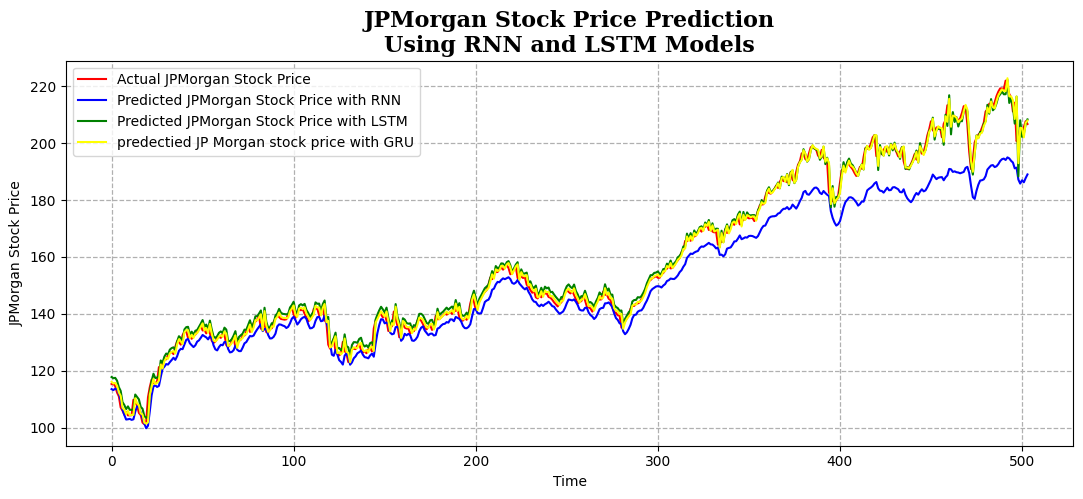

In [36]:
def plot_predictions(true_data, rnn_predictions, lstm_predictions):
    """
    Plots the true data along with predictions from RNN and LSTM models.

    Parameters:
    - true_data: Pandas Series or NumPy array containing the true data
    - rnn_predictions: Pandas Series or NumPy array containing the predictions
    from RNN model
    - lstm_predictions: Pandas Series or NumPy array containing the predictions
     from LSTM model

    Returns:
    - None
    """
    plt.figure(figsize=(13, 5))
    plt.plot(true_data, color='red', label='Actual JPMorgan Stock Price')
    plt.plot(rnn_predictions, color='blue',
             label='Predicted JPMorgan Stock Price with RNN')
    plt.plot(lstm_predictions, color='green',
             label='Predicted JPMorgan Stock Price with LSTM')
    plt.plot(gru_predictions,color='yellow',label='predectied JP Morgan stock price with GRU')

    # Title, labels, and legend
    plt.title('JPMorgan Stock Price Prediction\nUsing RNN and LSTM Models',
              fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel('JPMorgan Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()

    # Saving the plot
    plt.savefig('JPMorgan_stock_price_prediction_RNN_LSTM.png',
                dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

#  function call with actual data
# Replace actual_prices, rnn_predictions, and lstm_predictions
#with your actual data
plot_predictions(actual_prices, rnn_predictions, lstm_predictions)

Finded that LSTM have less error comparing with other 2 models.so predicting the next 25 days of jp morgan stock using LSTM model.

**FORECASTING**

In [37]:
def pred_future_stock(model, base_data, days_to_predict,
                      scaler, look_back=2000):
  """
  Predict future stock values using the given LSTM 'model'.
  Parameters:
  - model: Trained GRU model.
  - base_data: Time series data used as the starting point for prediction.
  - days_to_predict: Number of future days to predict.
  - scaler: Scaler used for data normalization.
  - look_back: Number of past days to consider for each prediction.
  Returns:
  - numpy.ndarray: Predicted future stock values.
  """
  # Start with the last days of the base data
  input_data = base_data[-look_back:].reshape(1, look_back, 1)

  # Predict future days
  future_predictions = []

  for _ in range(days_to_predict):

    # Make a prediction
    prediction = model.predict(input_data)

    # Append the prediction
    future_predictions.append(prediction[0, 0])

    # Update the input data to include the prediction and
    # exclude the oldest data point.
    # Correctly reshape the prediction to
    # (1, 1, 1) before appending
    input_data = np.append(input_data[:, 1:, :],
                           prediction.reshape(1, 1, 1), axis=1)

  # Invert the scaling
  reshaped = np.array(future_predictions).reshape(-1, 1)
  future_predictions = scaler.inverse_transform(reshaped)

  return future_predictions

In [38]:
# predicting the stock price by calling the function
days_to_pred = 30
future_days = pred_future_stock(gru_model, scaled_data, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

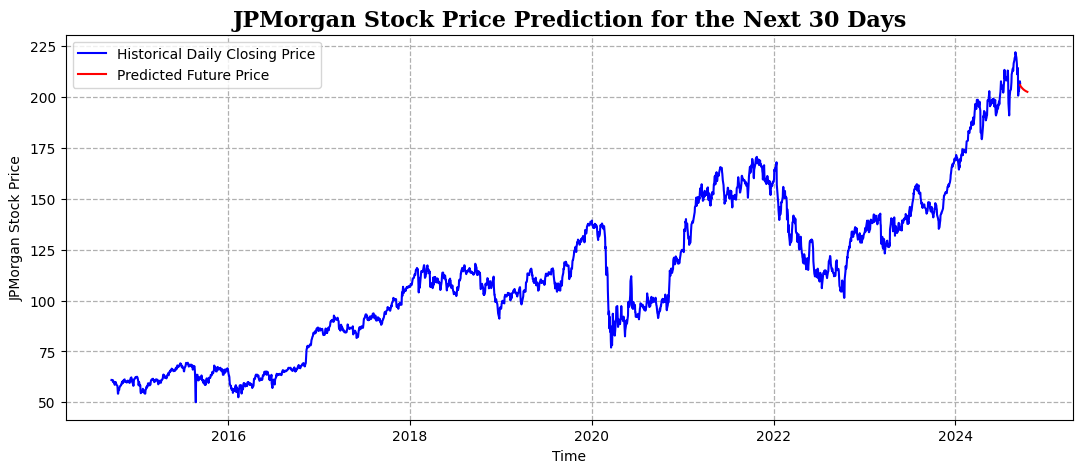

In [39]:
def plot_future_predictions(data, future_days):
    """
    Plots the predicted future prices along with historical data.

    Parameters:
    - data: Pandas DataFrame containing historical data with index as datetime
    - future_days: NumPy array containing predicted future prices

    Returns:
    - None
    """
    # Adjusting the dimensions of future_days array
    future_days = future_days.squeeze()

    # Plotting the predictions
    predicted_dates = pd.date_range(start=data.index[-1],
                                    periods=len(future_days))
    plt.figure(figsize=(13, 5))
    plt.plot(data.index, data['Close'], color='blue',
             label='Historical Daily Closing Price')
    plt.plot(predicted_dates, future_days, color='red',
             label='Predicted Future Price')
    plt.title(f'JPMorgan Stock Price Prediction for the Next {len(future_days)} Days',
          fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel('JPMorgan Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()
    plt.show()

# Example function call with actual data
# Replace data and future_days with your actual data
plot_future_predictions(data, future_days)

It is showing an downward trend for next 30 days,which is a good news for long term  investors.

**Tesla model**

In [40]:
# Scale the data to a range between 0 and 1 as LSTMs are sensitive to scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_tesla['Close'].values.reshape(-1,1))

In [41]:
# Create the time series data structure
look_back = 50
train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)

In [42]:
# Call the function to split the data into input-output datasets
# with a time step of 50
time_step = 50
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [43]:
# Display the shapes of the training and testing datasets
print(X_train.shape)
print(X_test.shape)

(1961, 50)
(503, 50)


In [44]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
# Compile and fit LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_generator, epochs=50, batch_size=32,
               validation_data=(X_test, Y_test))

Epoch 1/50
12/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0221

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0287 - val_loss: 0.0037
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - val_loss: 0.0330
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.6333e-04 - v

In [46]:
# Build the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(128, return_sequences=True,
                        input_shape=(X_train.shape[1],1)))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(1))

In [47]:
# Compile and fit RNN model
rnn_model.compile(loss = 'mean_squared_error', optimizer='adam')
rnn_model.fit(train_generator, epochs=50, batch_size=32)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.1425
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0021
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0010
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0027
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.1390e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0019
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0029
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0020
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0045
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0102
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 13/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011
Epoch 14/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 8.8468e-04
Epoch 15/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.8

In [48]:
from tensorflow.keras.layers import GRU, Dense
# Define the LSTM model
gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
gru_model.add(GRU(128, return_sequences=True))
gru_model.add(GRU(64))
gru_model.add(Dense(1))

In [49]:
# Compile and fit LSTM model
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(train_generator, epochs=50, batch_size=32,
               validation_data=(X_test, Y_test))

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0178 - val_loss: 0.0055
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.7599e-04 - val_loss: 0.0020
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1953e-04 - val_loss: 9.1417e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.9856e-04 - val_loss: 6.3277e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7904e-04 - val_loss: 0.0105
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.0533e-04 - val_loss: 0.0010
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7113e-04 - val_loss: 5.4775e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9715e-04 - val_loss: 4.3858e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0519e-04 - val_loss: 4.1154e-04
Epoch 12/50
9

In [50]:
# Predicting on the dataset with our models
rnn_predictions = rnn_model.predict(test_generator)
lstm_predictions = lstm_model.predict(test_generator)
gru_predictions = gru_model.predict(test_generator)

# Inverting out models
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)
actual_prices = scaler.inverse_transform(test_data[look_back:])

504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [51]:
vals1 = Y_test.reshape(-1, 1)
actual_values = scaler.inverse_transform(vals1)

In [52]:
def calculate_model_errors(actual_values, predictions):
    """
    Calculates MSE, MAE, and RMSE of the models.

    Parameters:
    - actual_values: NumPy array containing the actual values
    - predictions: NumPy array containing the predicted values

    Returns:
    - tuple: (mse, mae, rmse)
      - mse: Mean Squared Error
      - mae: Mean Absolute Error
      - rmse: Root Mean Squared Error
    """
    # Calculate MSE
    mse = mean_squared_error(actual_values, predictions[:-1])

    # Calculate MAE
    mae = np.mean(np.abs(actual_values - predictions[:-1]))

    # Calculate RMSE
    rmse = np.sqrt(mse)

    return mse, mae, rmse

#  function call
rnn_mse, rnn_mae, rnn_rmse = calculate_model_errors(actual_values, rnn_predictions)
lstm_mse, lstm_mae, lstm_rmse = calculate_model_errors(actual_values, lstm_predictions)
gru_mse, gru_mae, gru_rmse = calculate_model_errors(actual_values, gru_predictions)

print(f'Mean Squared Error of RNN Model: {rnn_mse}')
print(f'Mean Absolute Error of RNN Model: {rnn_mae}')
print(f'Root Mean Squared Error of RNN Model: {rnn_rmse}')

print(f'Mean Squared Error of LSTM Model: {lstm_mse}')
print(f'Mean Absolute Error of LSTM Model: {lstm_mae}')
print(f'Root Mean Squared Error of LSTM Model: {lstm_rmse}')

print(f'Mean Squared Error of GRU Model: {gru_mse}')
print(f'Mean Absolute Error of GRU Model: {gru_mae}')
print(f'Root Mean Squared Error of GRU Model: {gru_rmse}')

Mean Squared Error of RNN Model: 160.88916720535153
Mean Absolute Error of RNN Model: 10.864404955156754
Root Mean Squared Error of RNN Model: 12.684209364613608
Mean Squared Error of LSTM Model: 71.98864761131959
Mean Absolute Error of LSTM Model: 6.521363078244402
Root Mean Squared Error of LSTM Model: 8.484612401949756
Mean Squared Error of GRU Model: 63.876962938931634
Mean Absolute Error of GRU Model: 6.074792350025822
Root Mean Squared Error of GRU Model: 7.992306484296734


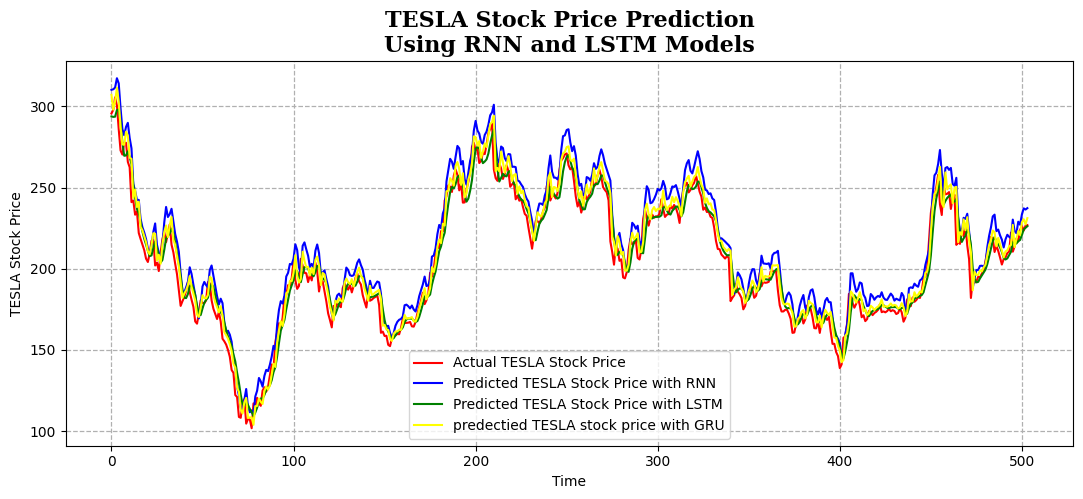

In [53]:
def plot_predictions(true_data, rnn_predictions, lstm_predictions):
    """
    Plots the true data along with predictions from RNN and LSTM models.

    Parameters:
    - true_data: Pandas Series or NumPy array containing the true data
    - rnn_predictions: Pandas Series or NumPy array containing the predictions
    from RNN model
    - lstm_predictions: Pandas Series or NumPy array containing the predictions
     from LSTM model
    - gru_predictions: Pandas Series or NumPy array containing the predictions
     from GRU model
    Returns:
    - None
    """
    plt.figure(figsize=(13, 5))
    plt.plot(true_data, color='red', label='Actual TESLA Stock Price')
    plt.plot(rnn_predictions, color='blue',
             label='Predicted TESLA Stock Price with RNN')
    plt.plot(lstm_predictions, color='green',
             label='Predicted TESLA Stock Price with LSTM')
    plt.plot(gru_predictions,color='yellow',label='predectied TESLA stock price with GRU')

    # Title, labels, and legend
    plt.title('TESLA Stock Price Prediction\nUsing RNN and LSTM Models',
              fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel('TESLA Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()

    # Saving the plot
    plt.savefig('TESLA_stock_price_prediction_RNN_LSTM.png',
                dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

#  function call with actual data
# Replace actual_prices, rnn_predictions, and lstm_predictions
#with your actual data
plot_predictions(actual_prices, rnn_predictions, lstm_predictions)

FORECASTING TESLA

In [54]:
# predicting the stock price by calling the function
days_to_pred = 30
future_days = pred_future_stock(gru_model, scaled_data, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

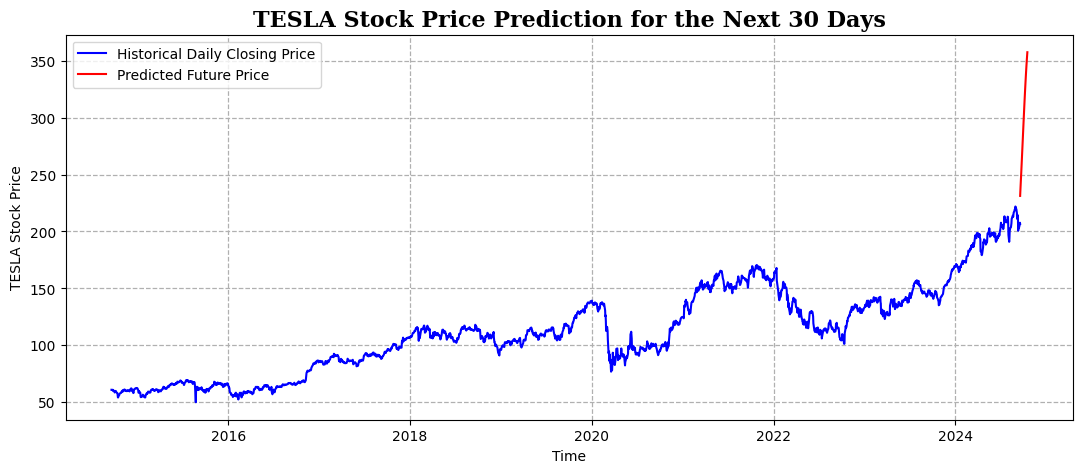

In [55]:
def plot_future_predictions(data, future_days):
    """
    Plots the predicted future prices along with historical data.

    Parameters:
    - data: Pandas DataFrame containing historical data with index as datetime
    - future_days: NumPy array containing predicted future prices

    Returns:
    - None
    """
    # Adjusting the dimensions of future_days array
    future_days = future_days.squeeze()

    # Plotting the predictions
    predicted_dates = pd.date_range(start=data.index[-1],
                                    periods=len(future_days))
    plt.figure(figsize=(13, 5))
    plt.plot(data.index, data['Close'], color='blue',
             label='Historical Daily Closing Price')
    plt.plot(predicted_dates, future_days, color='red',
             label='Predicted Future Price')
    plt.title(f'TESLA Stock Price Prediction for the Next {len(future_days)} Days',
          fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel('TESLA Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()
    plt.show()

# Example function call with actual data
# Replace data and future_days with your actual data
plot_future_predictions(data, future_days)

Tesla  showing an downward trend for next 30 days,which is a good news for short term investors.